# Tutorial 15: Mean Entropic Value at Risk (EVaR) Optimization

## 1. Downloading the data:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%%**********************]  25 of 25 completed


In [2]:
# Calculating returns

Y = data[assets].pct_change().dropna()

display(Y.head())

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-2.0257%,0.4057%,0.4036%,1.9692%,0.0179%,0.9305%,0.3678%,0.5784%,0.9483%,-1.1953%,...,1.5881%,0.0212%,2.8236%,0.9759%,0.6987%,1.7539%,-0.1730%,0.2410%,1.3735%,-1.0857%
2016-01-06,-11.4863%,-1.5879%,0.2411%,-1.7556%,-0.7727%,-1.2473%,-0.1736%,-1.1239%,-3.5867%,-0.9551%,...,0.5547%,0.0212%,0.1592%,-1.5647%,0.3108%,-1.0155%,-0.7653%,-3.0048%,-0.9035%,-2.9145%
2016-01-07,-5.1389%,-4.1922%,-1.6574%,-2.7699%,-1.1047%,-1.9769%,-1.2206%,-0.8855%,-4.6059%,-2.5394%,...,-2.2066%,-3.0309%,-1.0411%,-3.1557%,-1.6148%,-0.2700%,-2.2845%,-2.0570%,-0.5492%,-3.0019%
2016-01-08,0.2736%,-2.2705%,-1.6037%,-2.5425%,0.1099%,-0.2241%,0.5706%,-1.6402%,-1.7641%,-0.1649%,...,-0.1539%,-1.1366%,-0.7308%,-0.1448%,0.0896%,-3.3839%,-0.1117%,-1.1387%,-0.9719%,-1.1254%
2016-01-11,-4.3383%,0.1692%,-1.6851%,-1.0215%,0.0914%,-1.1791%,0.5674%,0.5287%,0.6616%,0.0330%,...,1.6436%,0.0000%,0.9869%,-0.1451%,1.2224%,1.4570%,0.5366%,-0.4607%,0.5800%,-1.9918%


## 2. Estimating Mean EVaR Portfolios

### 2.1 Calculating the portfolio that optimize EVaR ratio.

### 엔트로피 기반 가치 위험 (Entropic Value at Risk, EVaR)

엔트로피 기반 가치 위험(Entropic Value at Risk, EVaR)은 리스크 측정 방법 중 하나로, 자산의 손실 분포에서 높은 수준의 손실을 평가하는 데 사용됩니다. EVaR은 정보 이론에서 유래한 개념으로, 특정 신뢰 수준에서 손실을 평가하는 데 사용됩니다. 이는 특정 분포의 꼬리 리스크를 측정하는 데 매우 유용합니다.

### 정의 및 수학적 표현

EVaR는 주어진 신뢰 수준 $ \alpha $에서 손실의 상한을 엔트로피를 이용해 평가하는 값입니다. 이는 특히, 분포의 꼬리 부분(즉, 극단적인 손실)을 평가하는 데 강력한 도구입니다.

EVaR는 다음과 같이 정의됩니다:

$$
\text{EVaR}_\alpha = \inf_{\theta > 0} \left\{ \frac{1}{\theta} \left( \ln \mathbb{E} [e^{\theta L}] - \ln \alpha \right) \right\}
$$

여기서:
- $ L $은 손실 변수입니다.
- $ \alpha $는 신뢰 수준입니다.
- $ \theta $는 최적화 변수입니다.
- $ \mathbb{E} $는 기대값을 나타냅니다.
- $ e $는 자연로그의 밑입니다.

### EVaR의 특징

1. **위험 회피의 극단적인 경우**: EVaR는 손실의 극단적인 경우를 측정하는 데 유용합니다. 이는 VaR(Value at Risk)와 CVaR(Conditional Value at Risk)보다 더 보수적인 리스크 평가를 제공합니다.
2. **정보 이론과의 연관성**: EVaR는 정보 이론의 엔트로피 개념을 사용하여 손실을 평가합니다. 이는 리스크의 불확실성을 평가하는 데 강력한 도구가 됩니다.
3. **수학적 최적화 문제**: EVaR는 최적화 문제로 표현되며, 이는 컴퓨팅 리소스를 사용하여 효율적으로 해결될 수 있습니다.

### EVaR의 계산

EVaR를 계산하는 과정은 보통 수학적 최적화 문제로 풀립니다. 이는 손실 분포의 기대값과 관련된 최적화 문제를 해결하는 것으로, 다음 단계를 포함합니다:

1. **손실 변수의 정의**: 손실 변수를 정의합니다. 이는 자산 또는 포트폴리오의 수익률에서 파생될 수 있습니다.
2. **기대값 계산**: 손실 변수에 대한 기대값 $ \mathbb{E}[e^{\theta L}] $를 계산합니다.
3. **최적화 문제 해결**: 주어진 신뢰 수준 $ \alpha $에서 최적의 $ \theta $를 찾아 EVaR를 계산합니다.

### EVaR의 예시

다음은 Python을 사용하여 EVaR를 계산하는 예제입니다. 이 예제에서는 SciPy 라이브러리를 사용하여 최적화 문제를 해결합니다:

```python
import numpy as np
from scipy.optimize import minimize

def evar(losses, alpha):
    def objective(theta):
        return (1 / theta) * (np.log(np.mean(np.exp(theta * losses))) - np.log(alpha))
    
    result = minimize(objective, x0=1, bounds=[(1e-10, None)])
    if result.success:
        return result.fun
    else:
        raise ValueError("Optimization failed")

# 예제 손실 데이터 (예: 주식 수익률의 음수 값)
losses = np.array([-0.05, -0.1, -0.2, -0.15, -0.3])

# 신뢰 수준 설정 (예: 95%)
alpha = 0.05

# EVaR 계산
evar_value = evar(losses, alpha)
print(f"Entropic Value at Risk (EVaR) at {alpha*100}% confidence level: {evar_value:.4f}")
```

### EVaR의 장점과 단점

#### 장점

1. **보수적인 리스크 평가**: EVaR는 손실의 극단적인 경우를 측정하므로, 매우 보수적인 리스크 평가를 제공합니다.
2. **정보 이론의 사용**: 엔트로피를 이용하여 불확실성을 평가하는 데 강력한 도구입니다.
3. **최적화 문제로 해결 가능**: 수학적 최적화 문제로 표현되어 컴퓨터를 이용해 효율적으로 해결될 수 있습니다.

#### 단점

1. **계산 복잡성**: EVaR는 계산이 복잡할 수 있으며, 최적화 문제를 해결해야 하는 추가적인 계산 부담이 있습니다.
2. **데이터 요구**: 정확한 EVaR 계산을 위해 충분히 많은 손실 데이터가 필요합니다.

### 요약

엔트로피 기반 가치 위험(Entropic Value at Risk, EVaR)는 손실 분포에서 극단적인 리스크를 측정하는 데 사용되는 강력한 도구입니다. 정보 이론의 엔트로피 개념을 활용하여 손실의 상한을 평가하며, 이는 보수적인 리스크 평가를 가능하게 합니다. EVaR는 특히 리스크 관리 및 포트폴리오 최적화에서 중요한 역할을 할 수 있습니다.

In [3]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimum portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:

port.solvers = ['SCS'] # It is recommended to use mosek when optimizing EVaR 
port.alpha = 0.05 # Significance level for CVaR, EVaR y CDaR 
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'EVaR' # Risk measure used, this time will be EVaR
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.0003%,2.2960%,7.0949%,0.0001%,0.0001%,26.9746%,0.0000%,0.0000%,0.0001%,0.0001%,...,0.8100%,0.0000%,0.0001%,0.0002%,0.0001%,13.6173%,0.0000%,0.0002%,0.0001%,0.0001%


### 2.2 Plotting portfolio composition

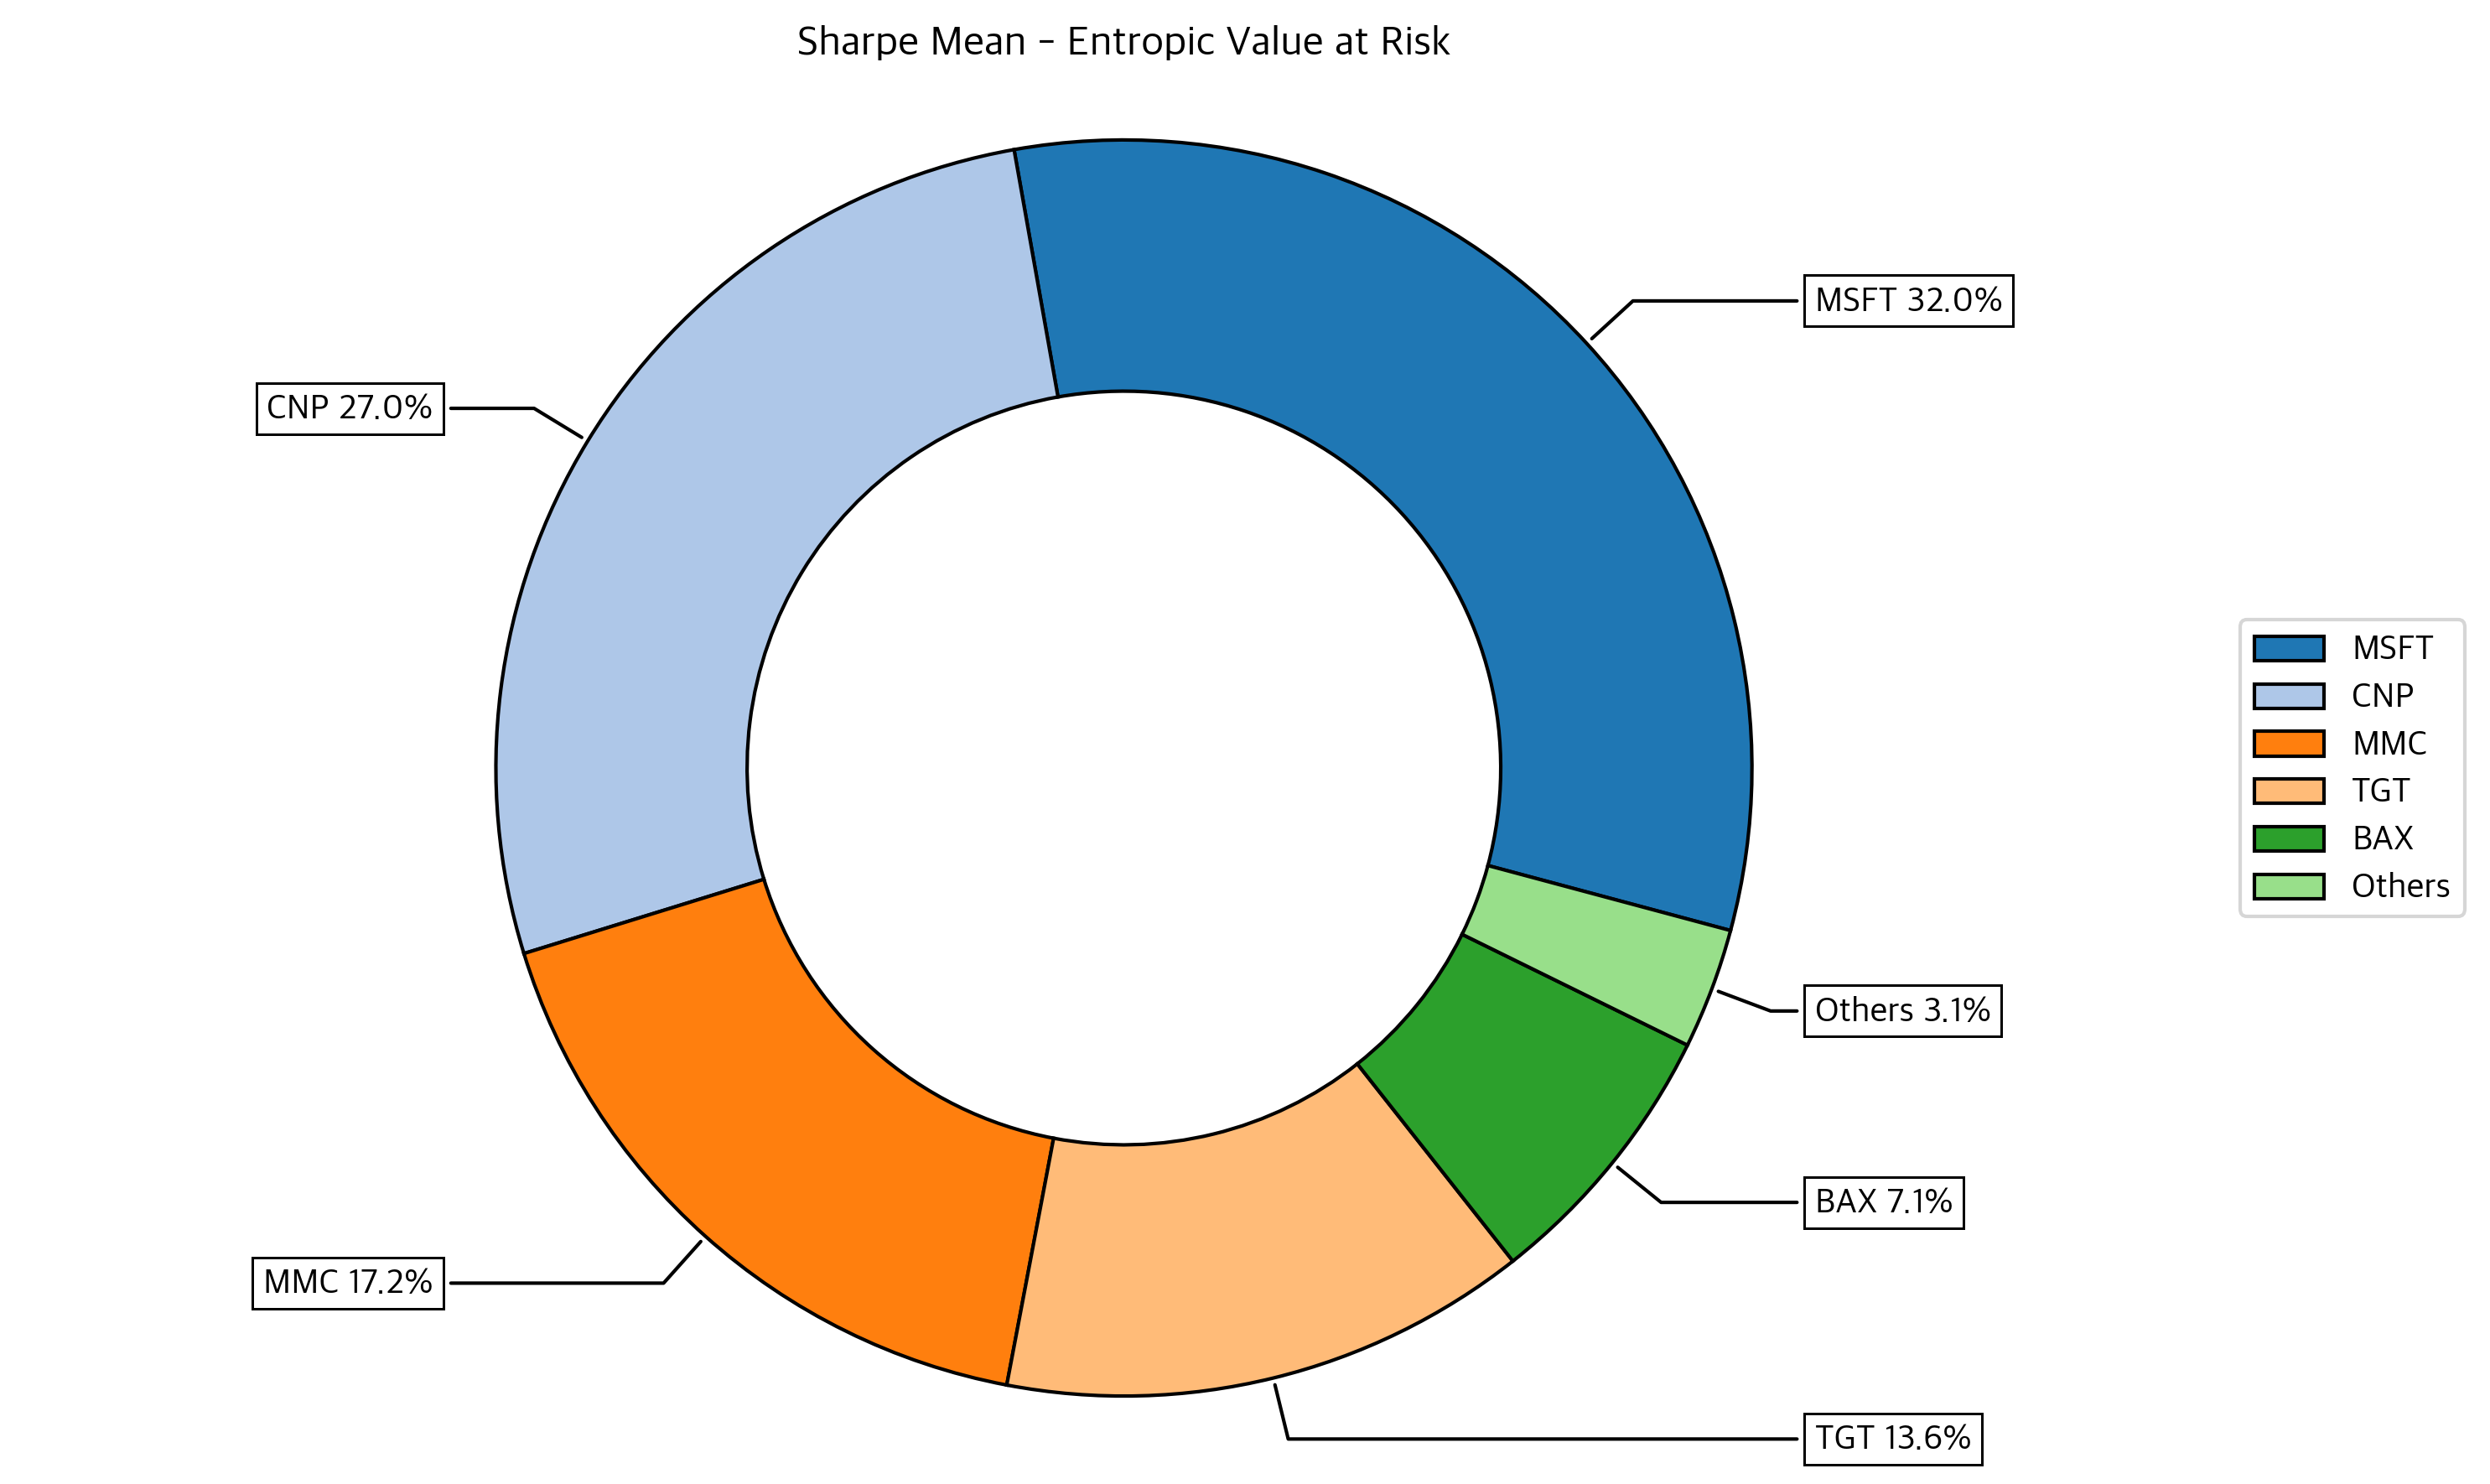

In [4]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean - Entropic Value at Risk', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 2.3 Calculate efficient frontier

In [5]:
points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
0,0.0000%,0.0000%,0.6772%,7.9933%,1.7690%,8.1109%,10.1054%,0.0000%,0.0000%,0.0000%,...,4.9728%,0.0000%,19.3433%,0.0000%,0.0000%,12.0093%,0.0000%,0.0000%,6.3019%,0.0000%
1,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,...,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
2,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,...,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
3,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,...,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
4,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,...,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%


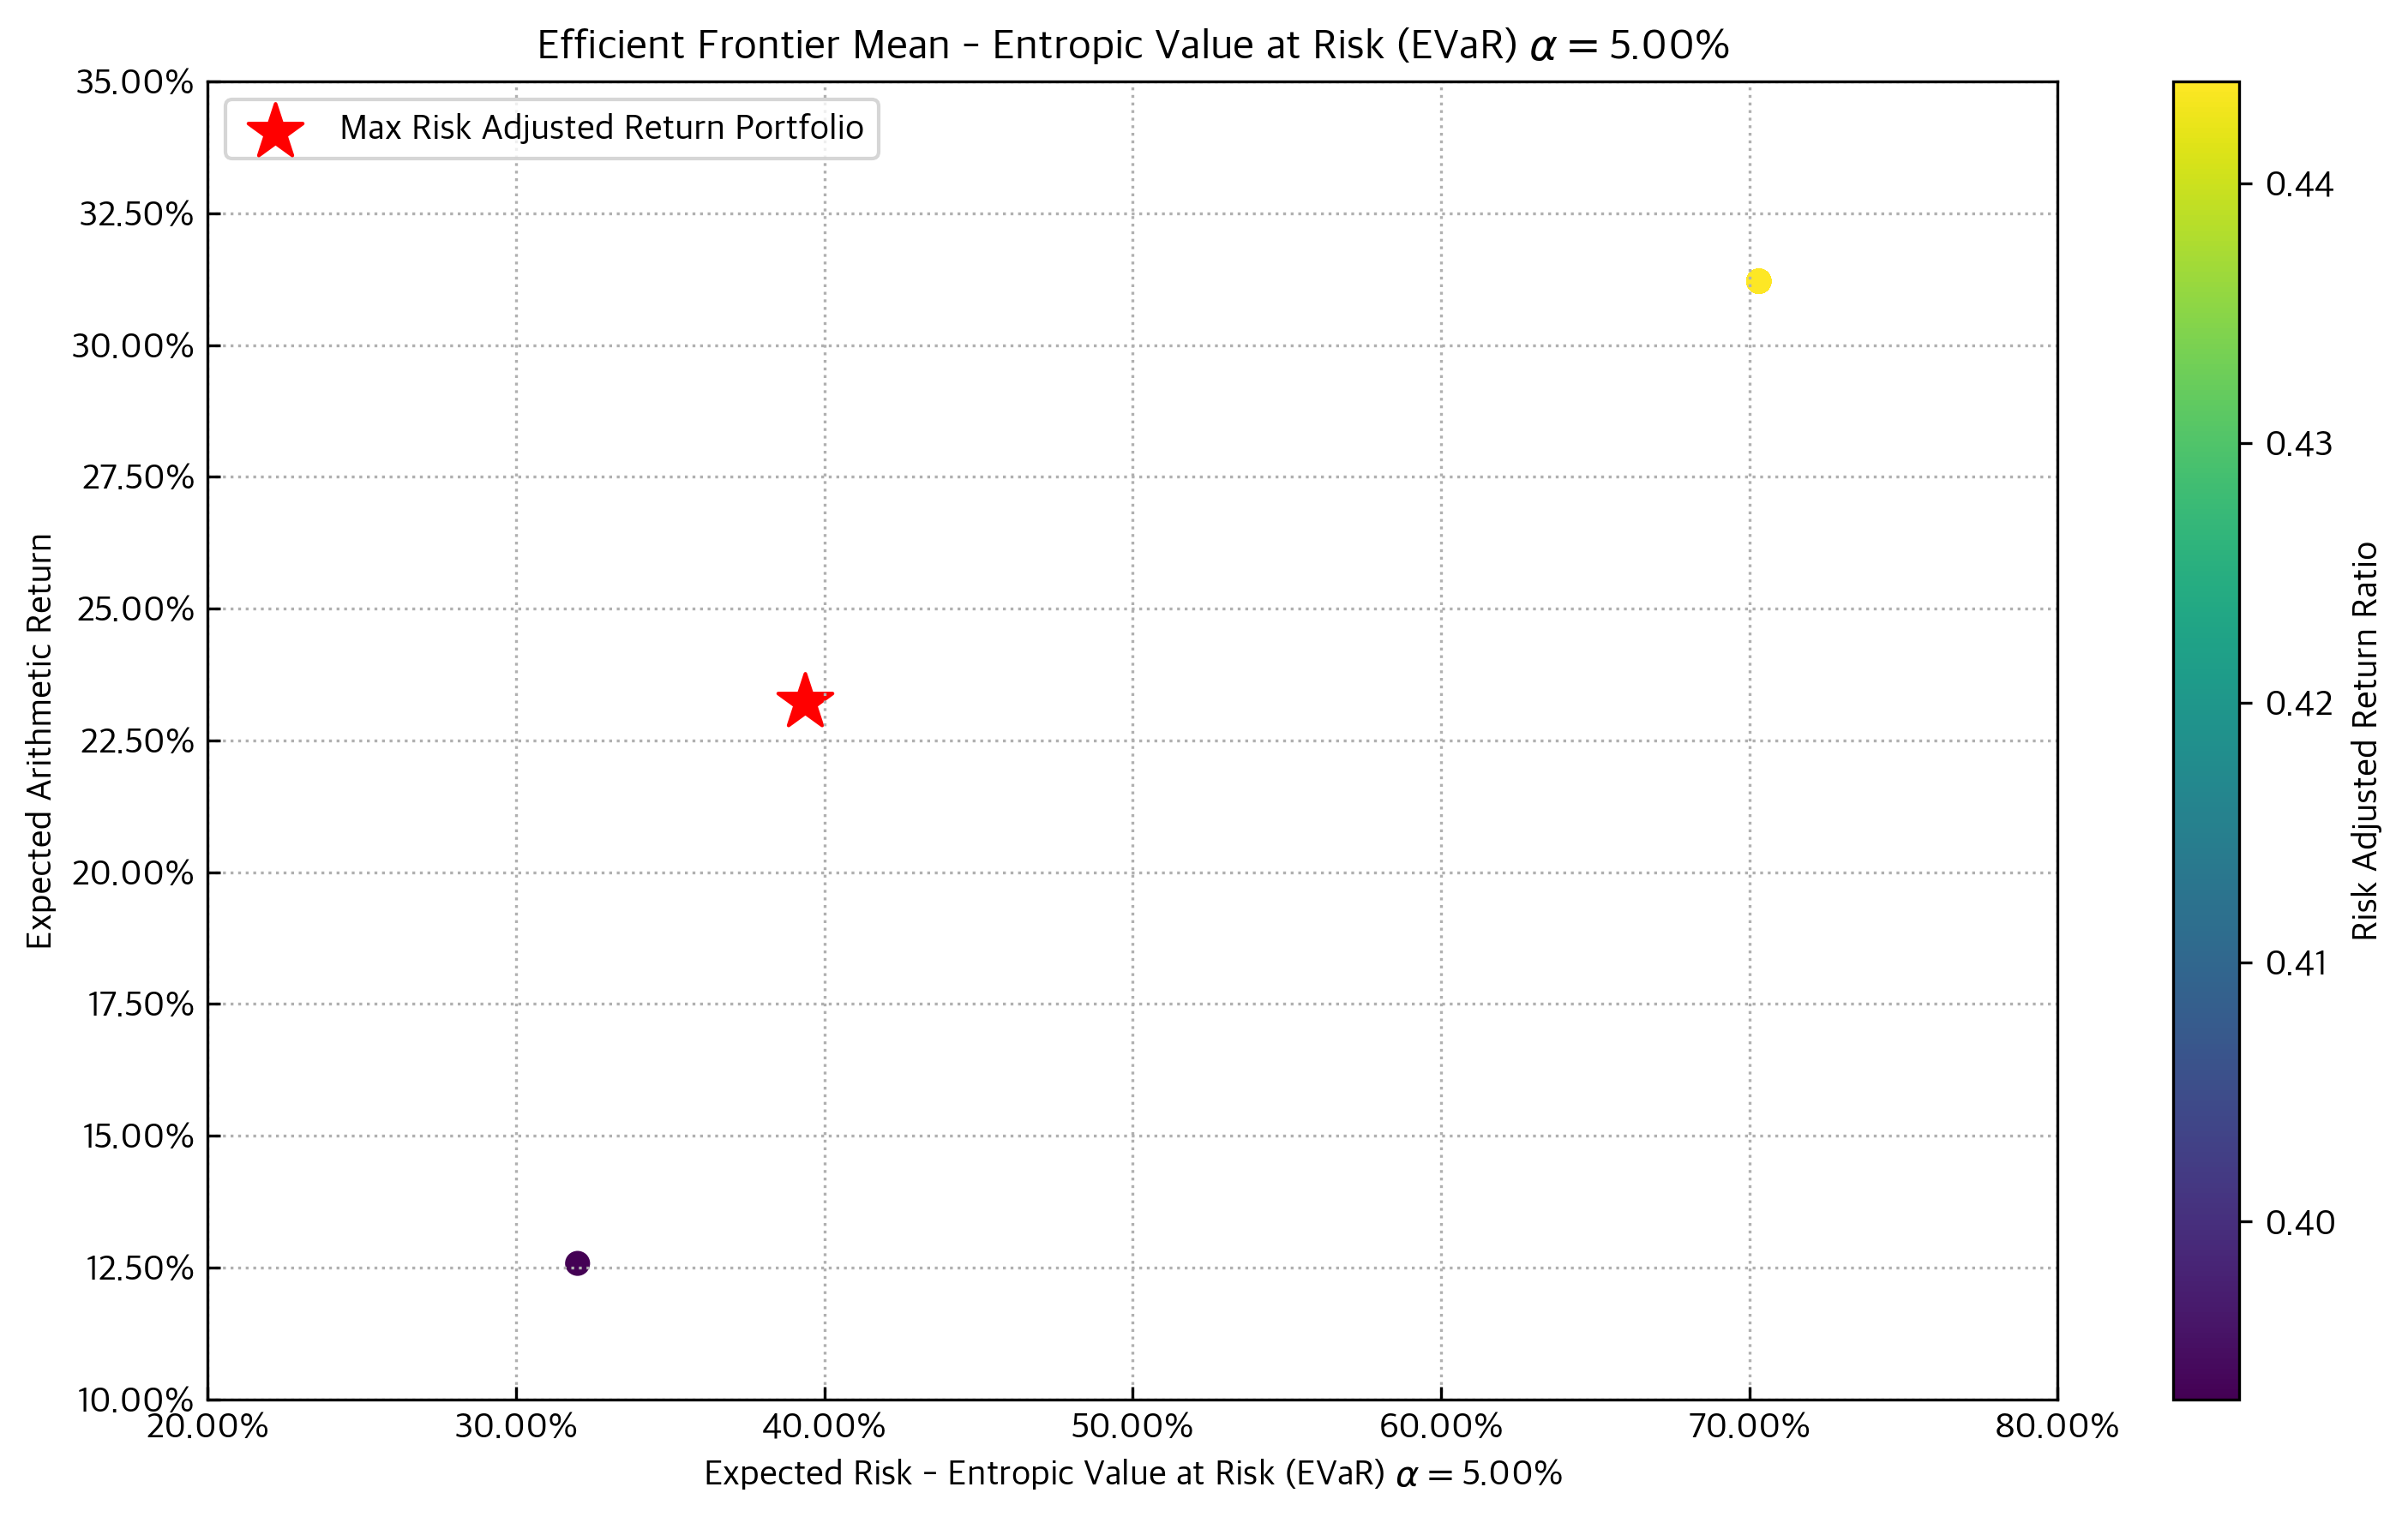

In [6]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

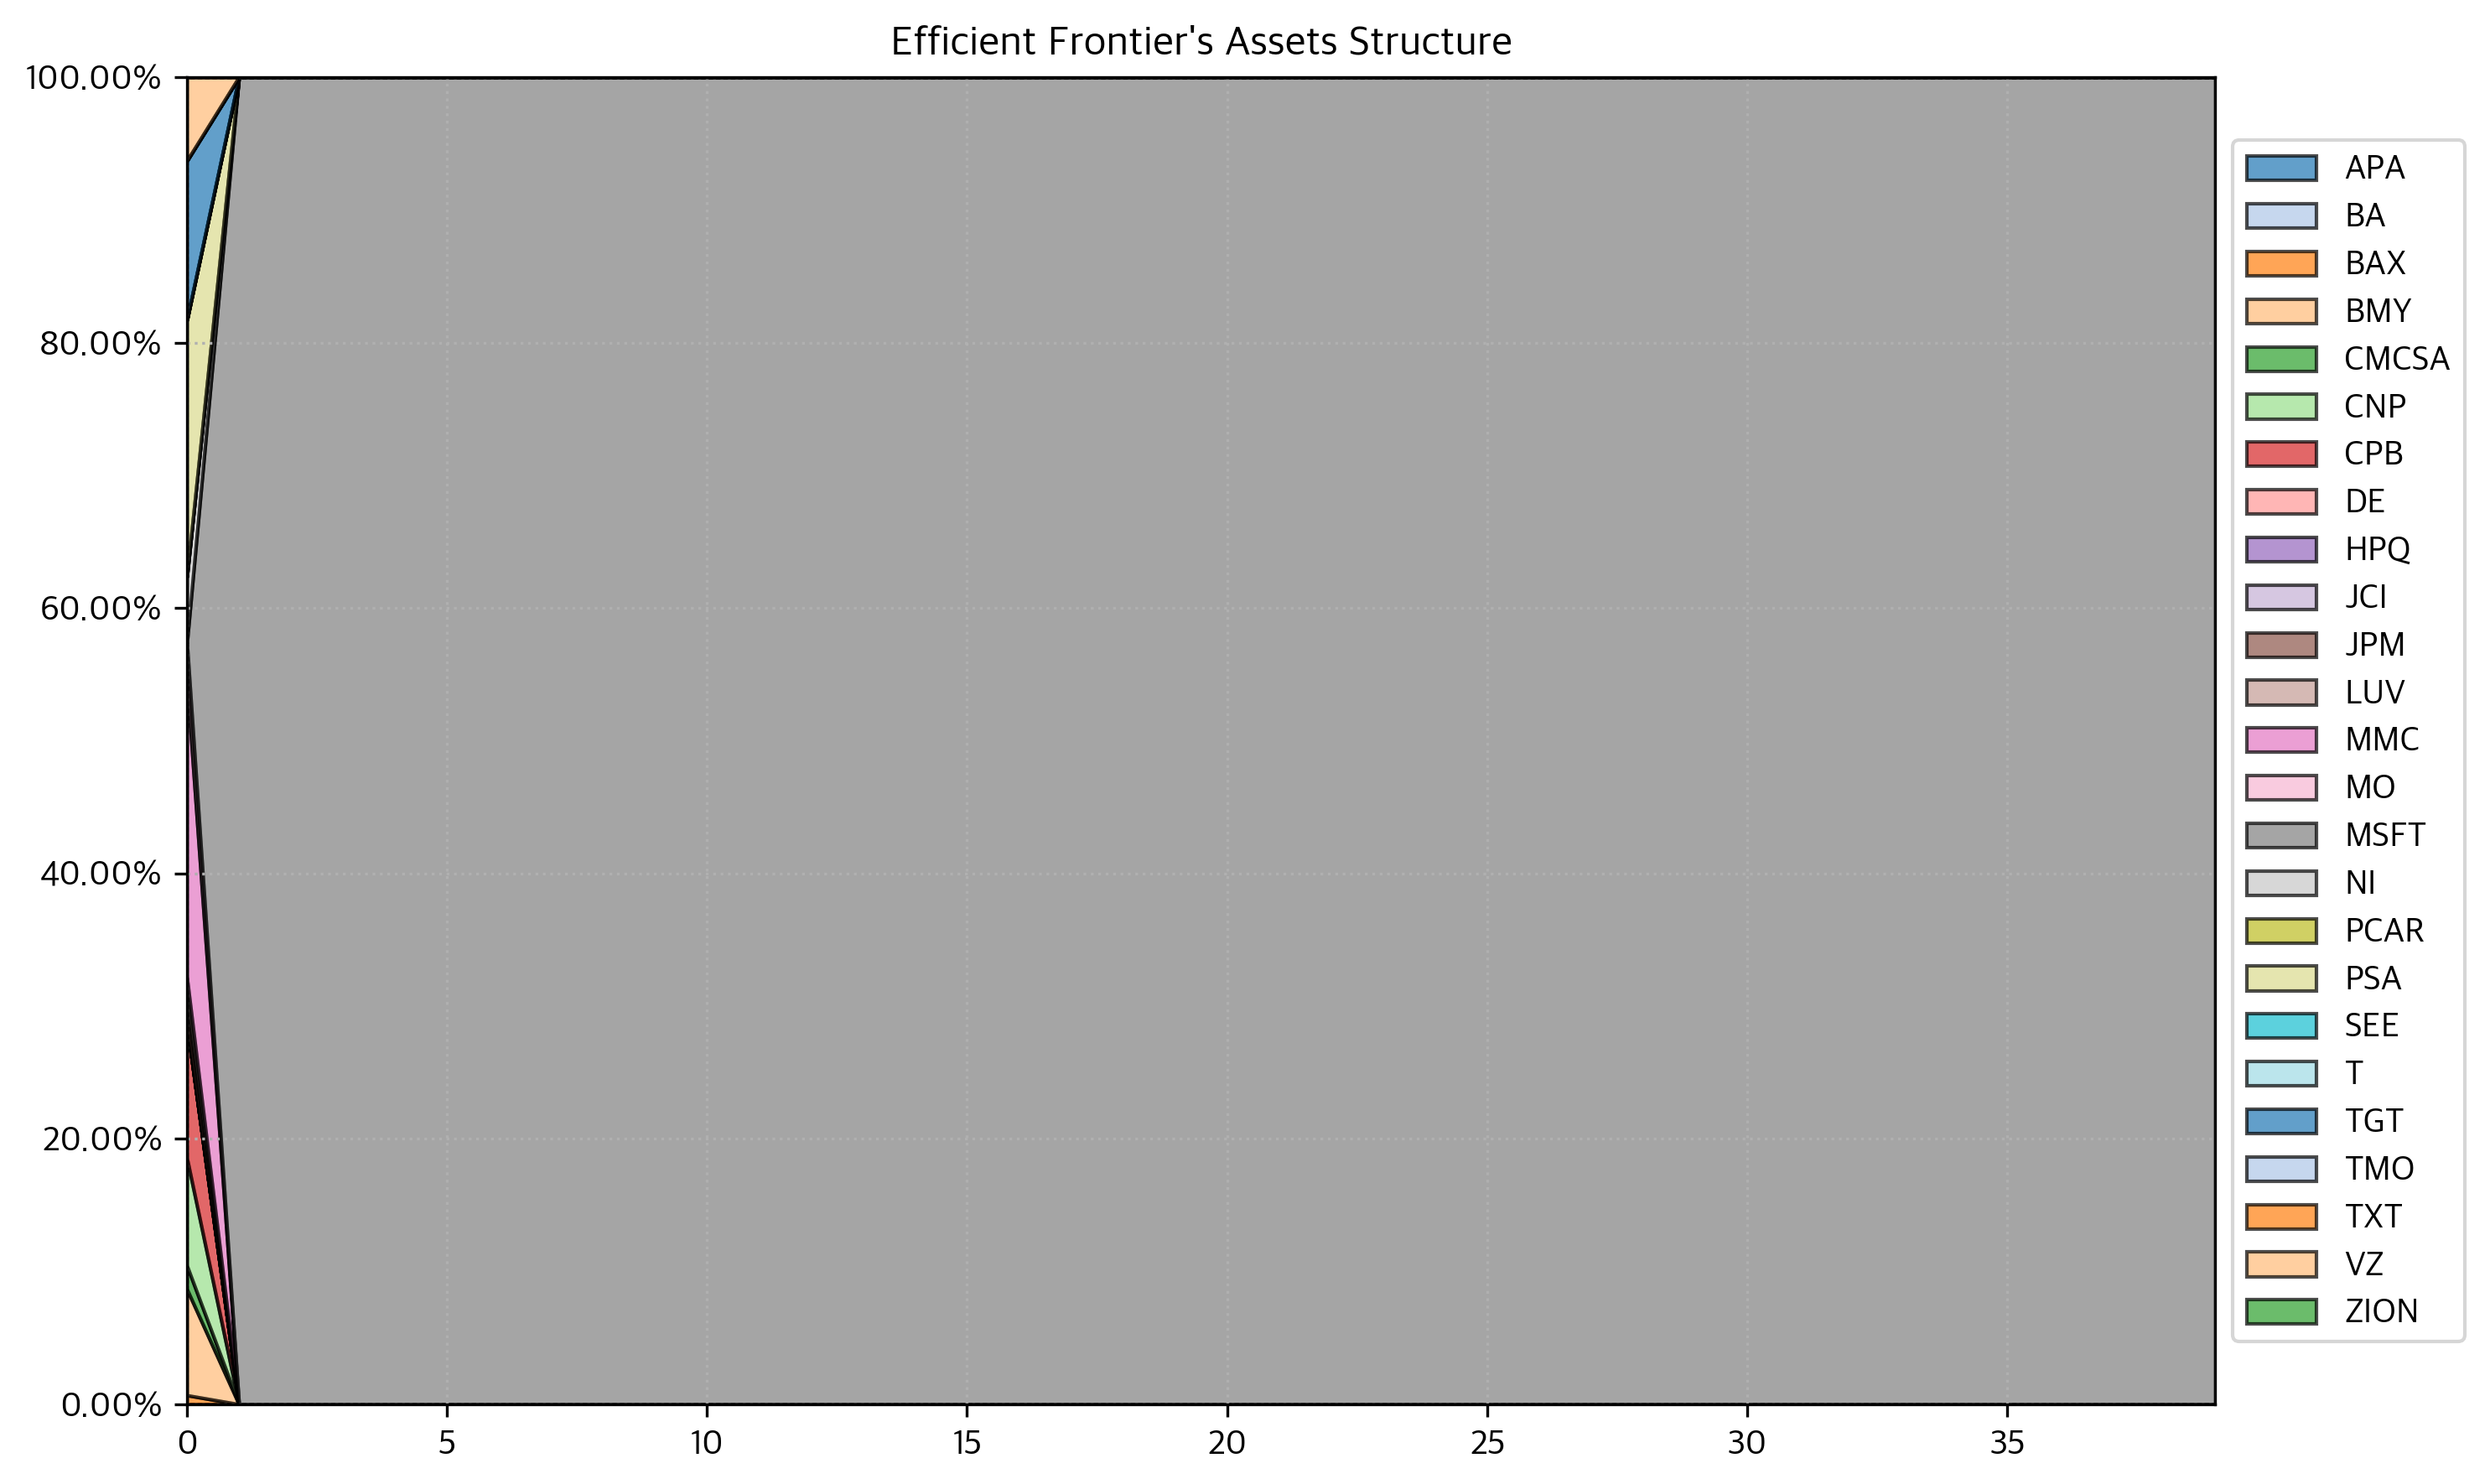

In [7]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

## 3. Estimating Risk Parity Portfolios for EVaR

### 3.1 Calculating the risk parity portfolio for EVaR.

In [8]:
b = None # Risk contribution constraints vector

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,2.7994%,2.7649%,3.4859%,4.6725%,3.5156%,5.4988%,7.7323%,2.9529%,2.6928%,3.2651%,...,6.3963%,3.2293%,6.0919%,3.5804%,4.0365%,5.5853%,3.2469%,3.1238%,4.1001%,2.7939%


### 3.2 Plotting portfolio composition

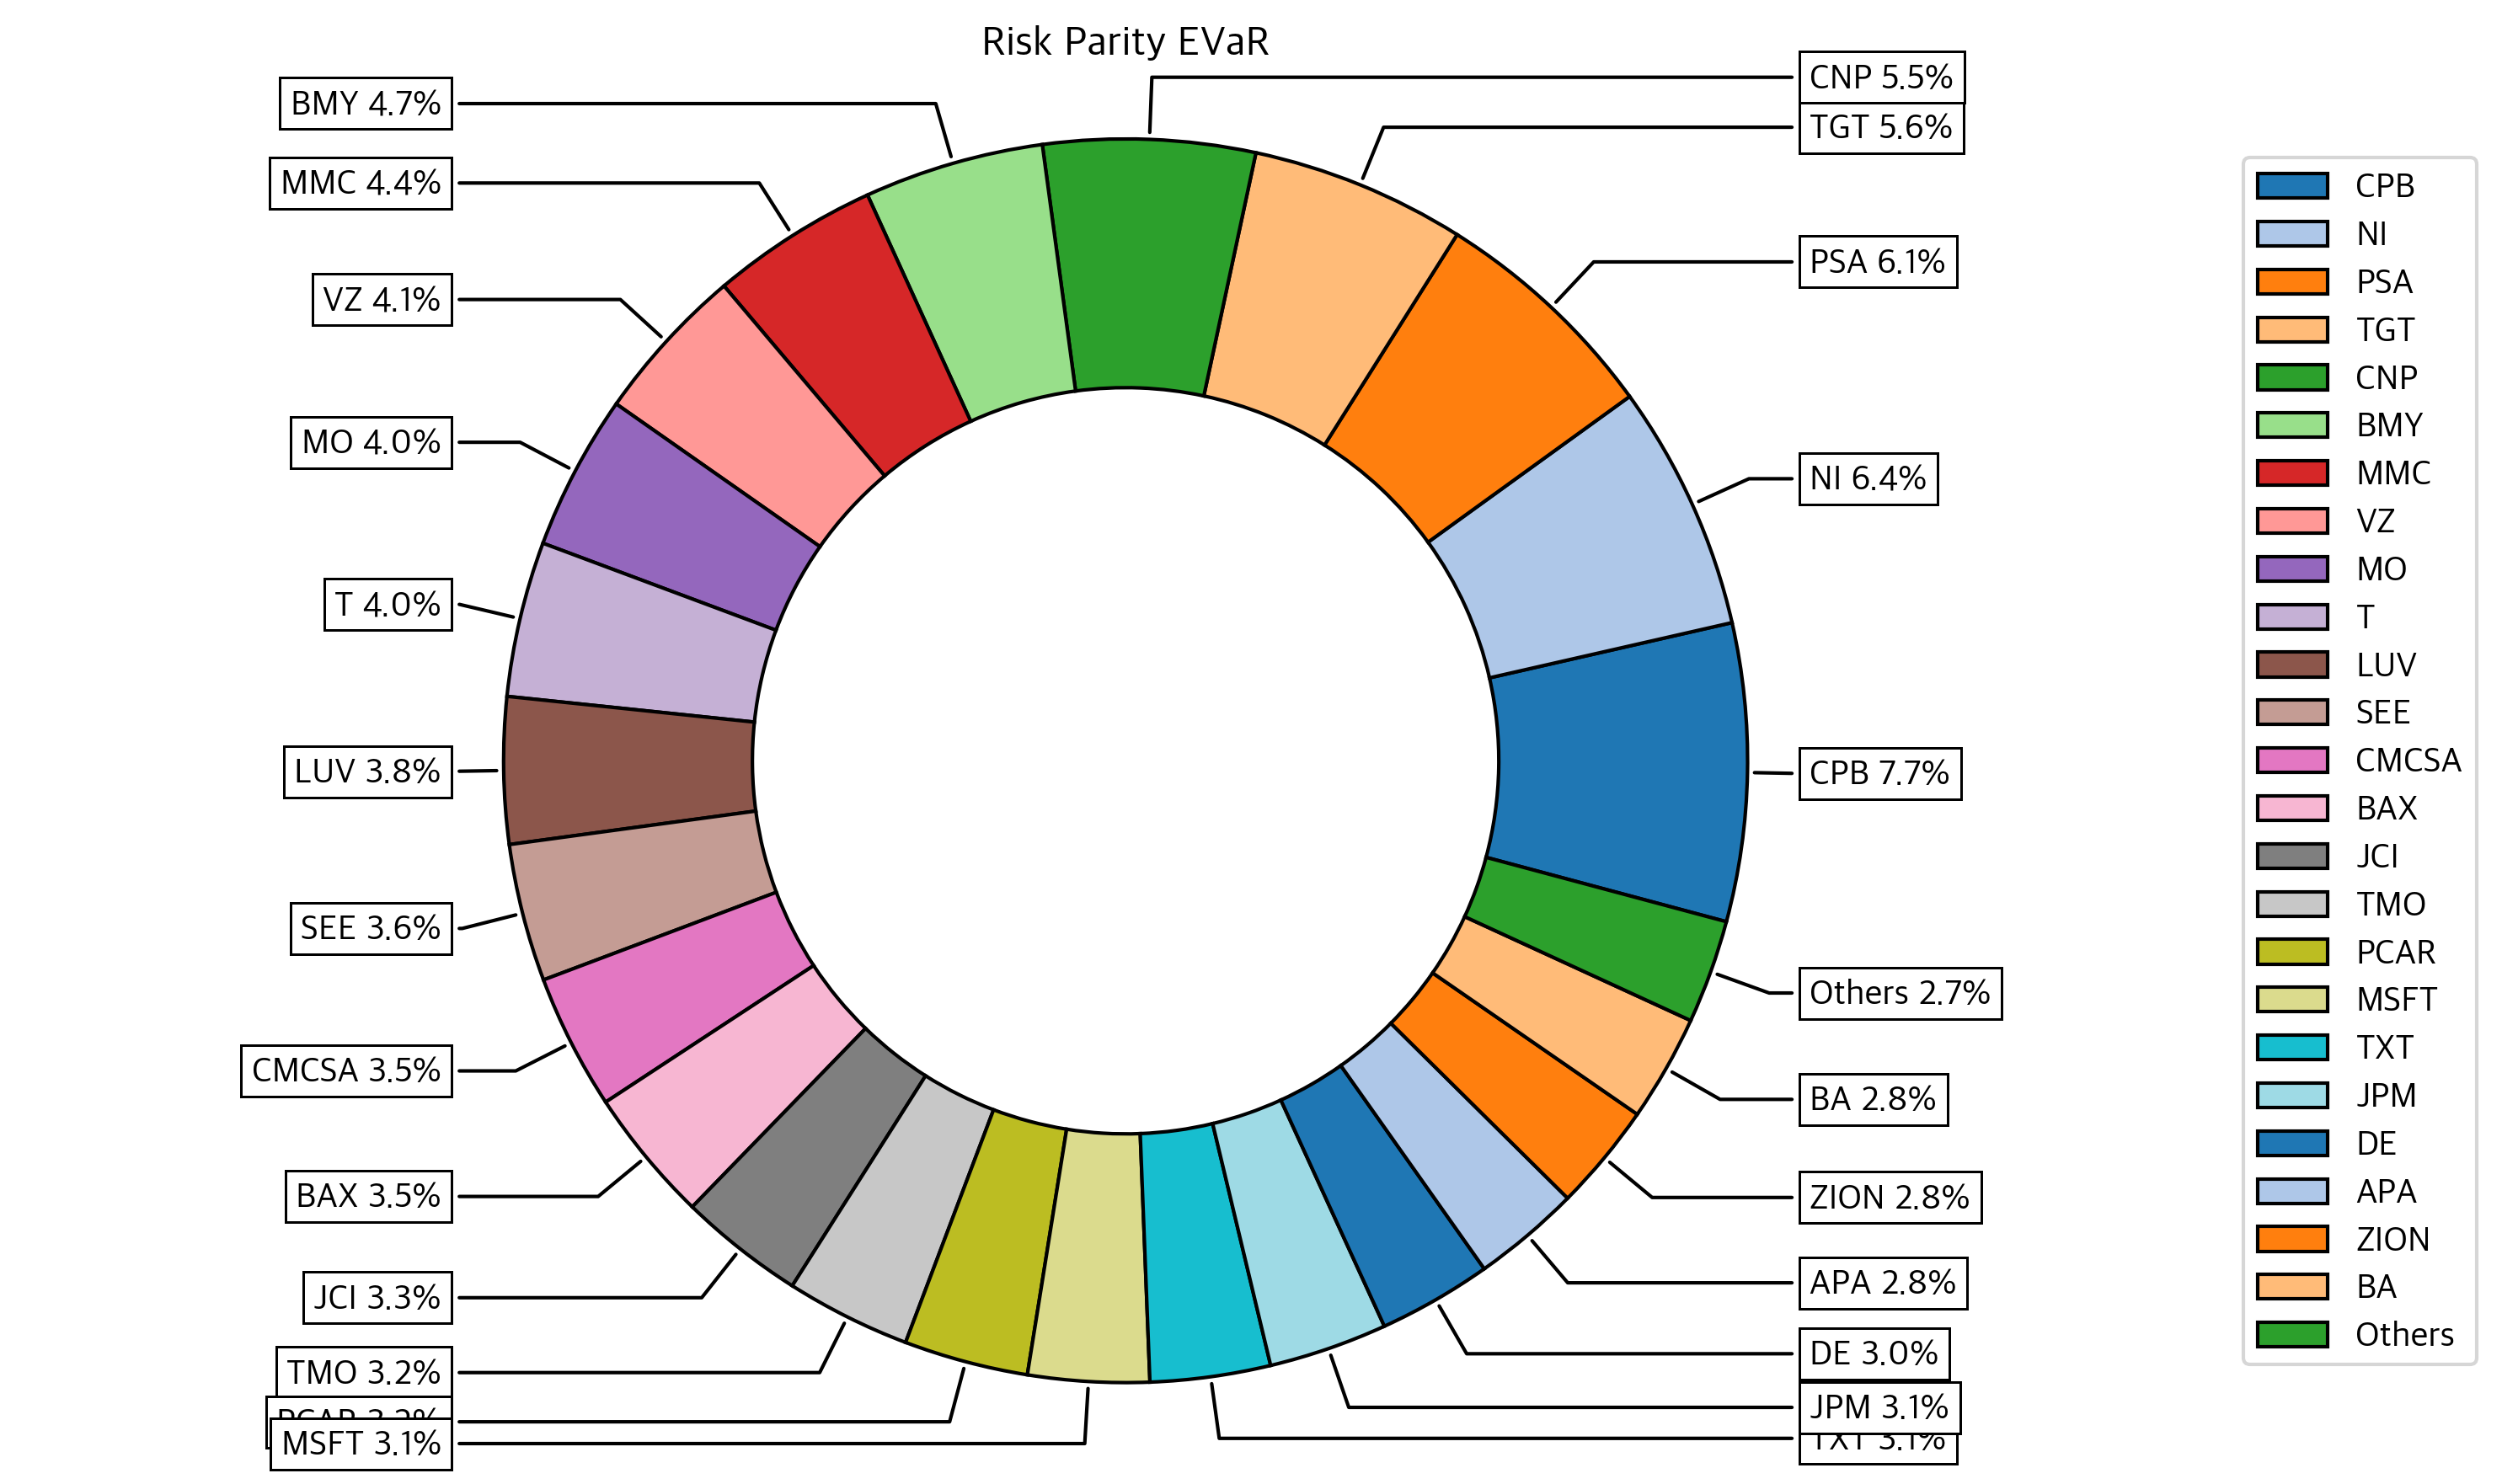

In [9]:
ax = rp.plot_pie(w=w_rp, title='Risk Parity EVaR', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

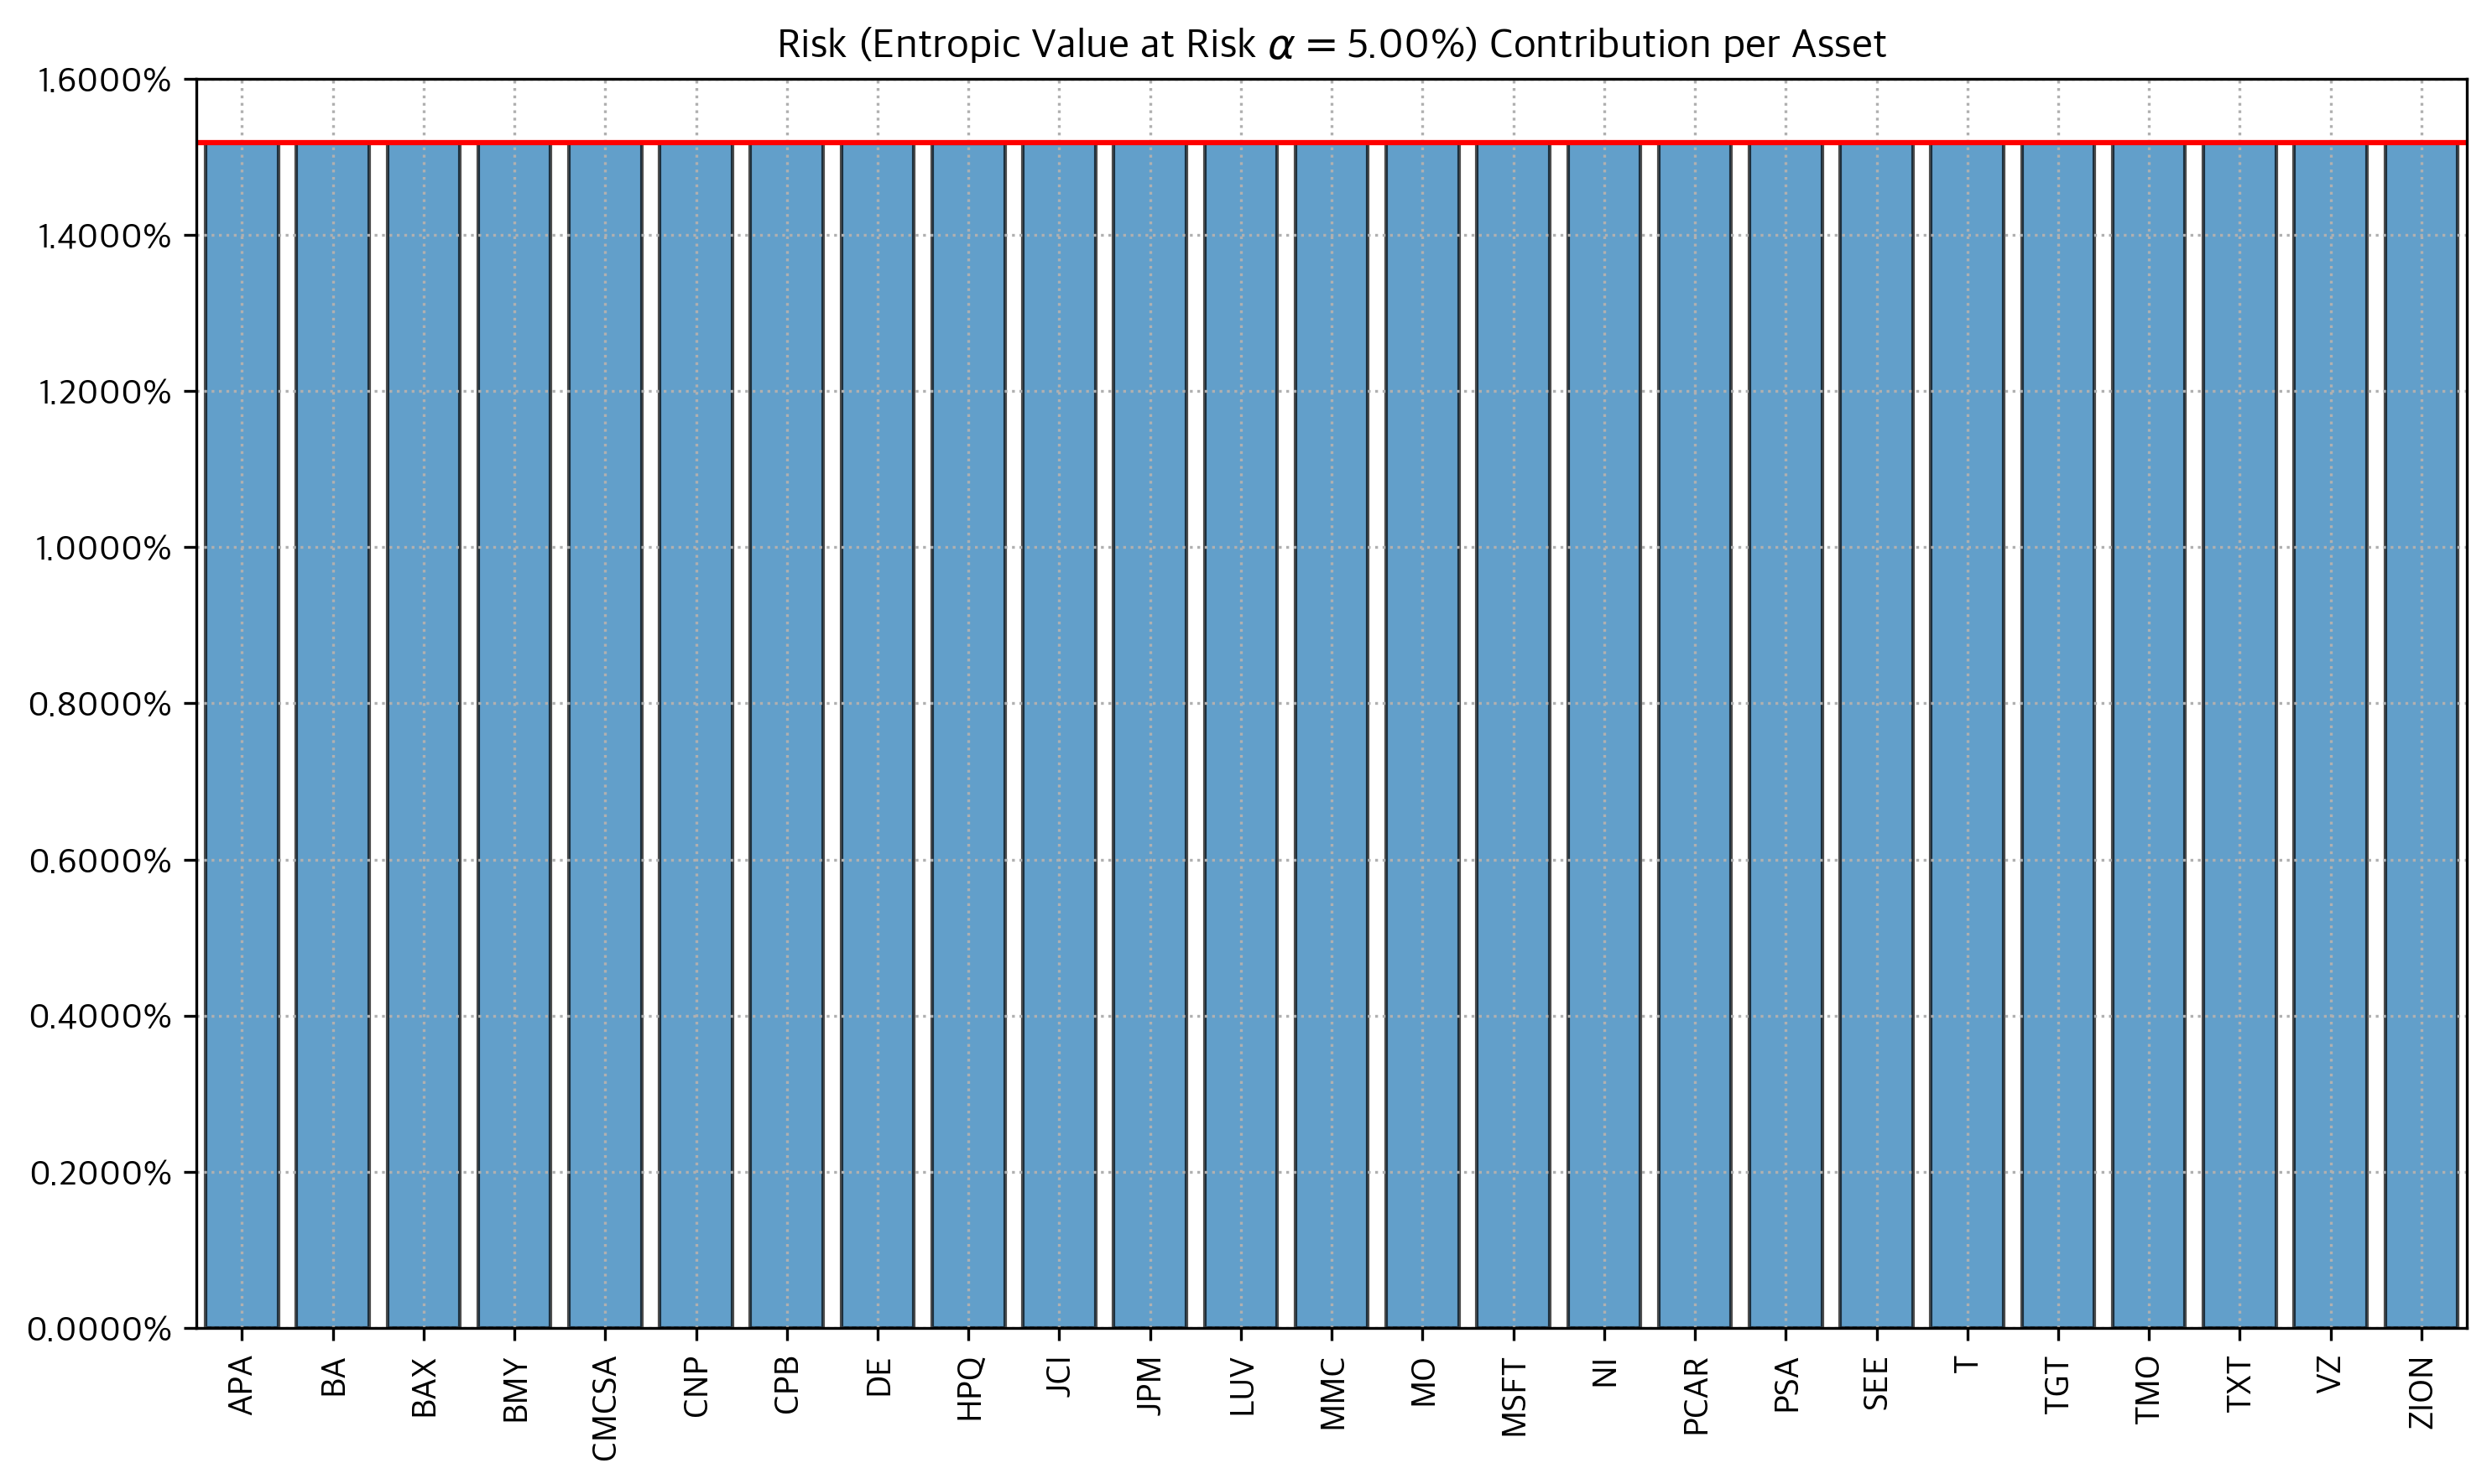

In [10]:
ax = rp.plot_risk_con(w_rp, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.05,
                      color="tab:blue", height=6, width=10, ax=None)